In [1]:
import pandas as pd
import pandas.plotting as pp
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# 1. Data Exploration

### 1.1 Data Describtion, check for the distributions

In [6]:
train=pd.read_csv('Data/train_joined.csv')


In [7]:
from pandas_profiling import ProfileReport
profile=ProfileReport(train,minimal=True)
profile

In [ ]:
profile.to_file("raw_data_profile.html")

In [3]:
train.describe(include='all')

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,DAYS_ENTRY_PAYMENT_y,AMT_INSTALMENT_y,AMT_PAYMENT_y,SK_ID_PREV_y,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,291635.000000,2.916430e+05,2.916350e+05,2.916430e+05,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,-327.784607,1.363388e+05,1.381792e+05,1.562327e+06,0.792308,1.040577,-1584.949140,-1596.954865,6.966585e+03,5.198133e+03
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,536.868180,2.454775e+05,2.477880e+05,4.744595e+05,0.417733,0.690206,913.707997,912.260714,1.436940e+04,1.442452e+04
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,-3071.000000,0.000000e+00,2.250000e-01,1.000001e+06,0.000000,1.000000,-2922.000000,-4921.000000,0.000000e+00,0.000000e+00
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,-384.000000,1.401248e+04,1.409717e+04,1.179536e+06,1.000000,1.000000,-2471.000000,-2483.000000,1.922423e+03,4.099500e+01
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,-66.000000,3.534192e+04,3.600000e+04,1.421135e+06,1.000000,1.000000,-1539.000000,-1553.000000,4.845240e+03,2.314800e+03
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,-26.000000,1.302350e+05,1.329875e+05,1.856249e+06,1.000000,1.000000,-713.000000,-727.000000,8.936010e+03,7.105748e+03
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,-1.000000,3.771488e+06,3.771488e+06,2.843492e+06,39.000000,67.000000,-3.000000,-3.000000,2.504590e+06,2.504590e+06


### 1.2 Check for the missing values

In [4]:
def missing_percent(df):
    total_count = df.isnull().sum().sort_values(ascending=False)
    calc_percent = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
    missing_df = pd.concat([total_count, calc_percent], axis=1, keys=['Count','Missing_percentage'])
    return missing_df

In [5]:
missing_train = missing_percent(train)

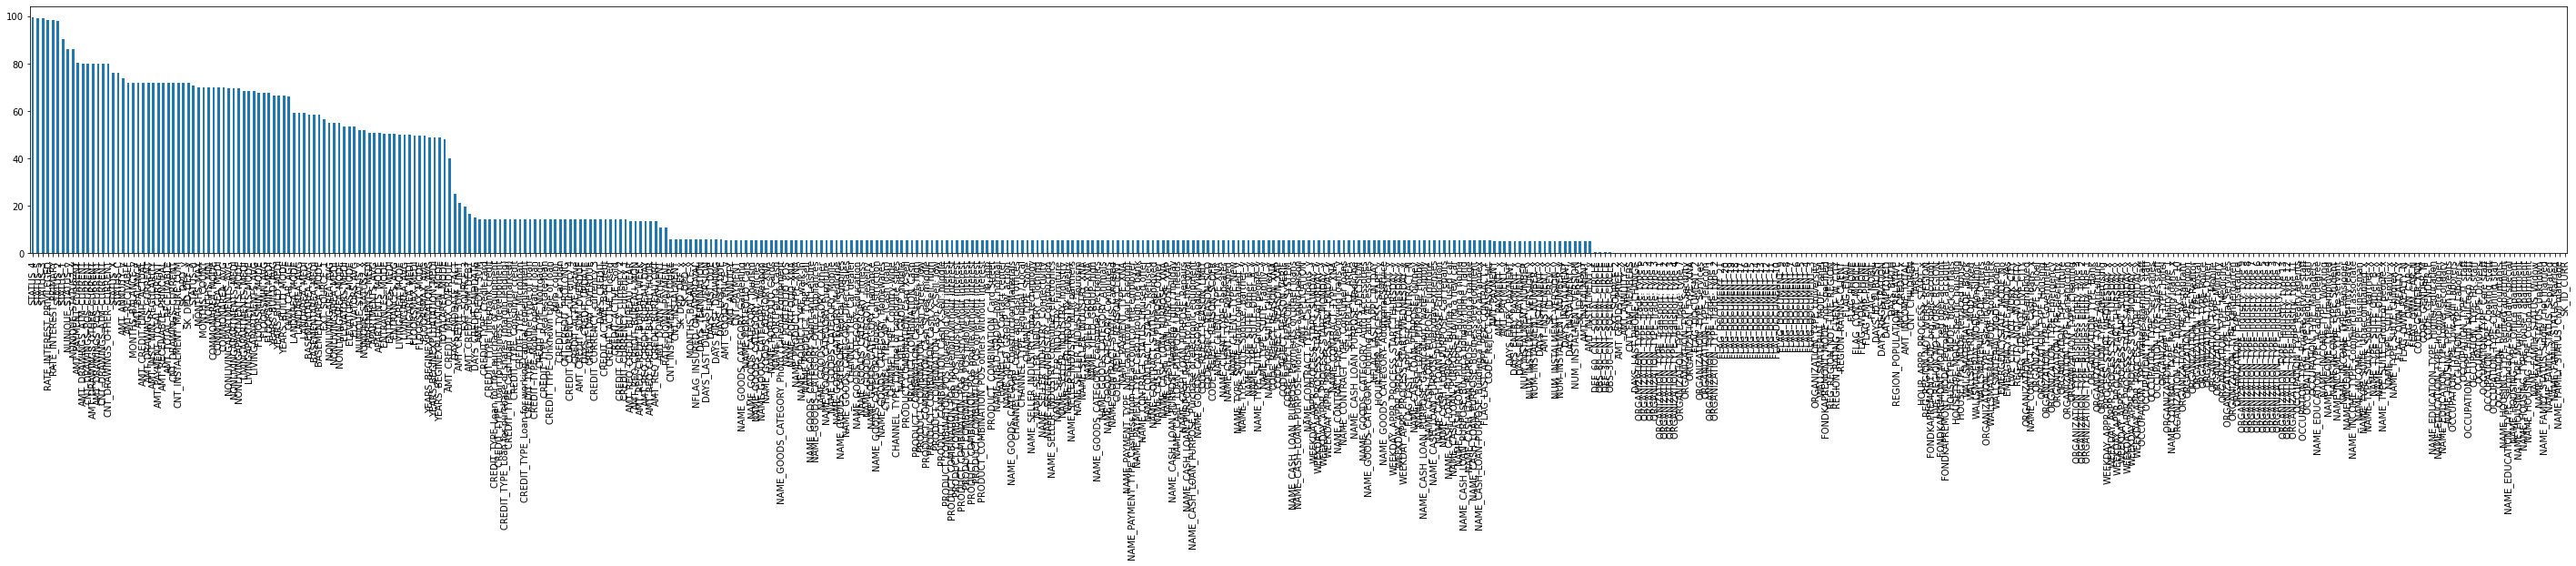

In [6]:
%matplotlib inline
# visually checking the percentage rate of the missing values 
missing_train.Missing_percentage.plot(kind='bar',figsize=(50,5))

### 1.3 Check for the class distribution balance

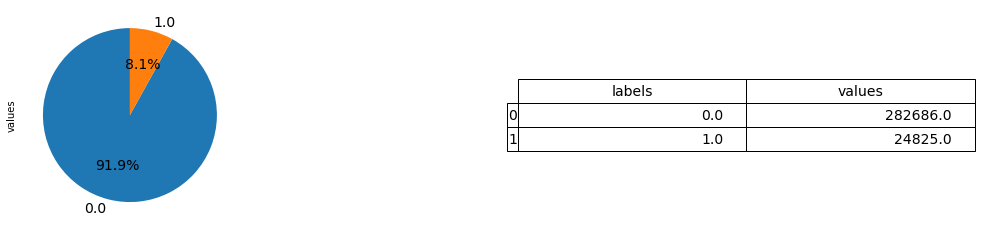

In [7]:
%matplotlib inline
contract_value_counts = train['TARGET'].value_counts()
contract_df = pd.DataFrame({'labels': contract_value_counts.index,'values': contract_value_counts.values})

# plot a piechart
ax1 = plt.subplot(121, aspect='equal')
contract_df.plot(kind='pie', y = 'values', ax=ax1, autopct='%1.1f%%', 
startangle=90, shadow=False, labels=contract_df['labels'], legend = False, fontsize=14, figsize=(9,4))

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
tbl = pp.table(ax2, contract_df, loc='right')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(2,2)
plt.show()

# 2. Data Cleaning & Fixing issues

### 2.1 Select Features that has less than 15% missing values

In [8]:
filtered_features= missing_train[missing_train['Missing_percentage']<15].index.values # count 231 features fildered

In [9]:
train = train[filtered_features]
missing_train_filtered = missing_percent(train)
missing_train_filtered.sort_values('Missing_percentage', ascending=False).head()

,Count,Missing_percentage
AMT_CREDIT_SUM,44021,14.315260
CREDIT_TYPE_Unknown type of loan,44020,14.314935
buro_count,44020,14.314935
CREDIT_TYPE_Mortgage,44020,14.314935
CREDIT_TYPE_Mobile operator loan,44020,14.314935


In [10]:
print(train.shape)

(307511, 416)


In [11]:
print(missing_train_filtered.shape)

(416, 2)


#### 2.2 Scanning for Outliers

In [12]:
Y= train.TARGET.values
X = train.drop(columns=['TARGET'], axis=1)
train= X.mask((X - X.mean()).abs() > 2 * X.std())
train['TARGET']=Y
del X, Y

In [13]:
print(train.shape)

(307511, 416)


In [14]:
train = train[filtered_features]
missing_train_filtered = missing_percent(train)
missing_train_filtered.sort_values('Missing_percentage', ascending=False).head()

,Count,Missing_percentage
FLAG_WORK_PHONE,61308,19.936848
CREDIT_TYPE_Consumer credit,60985,19.831811
NAME_TYPE_SUITE_Unaccompanied_x,58985,19.181428
AMT_REQ_CREDIT_BUREAU_QRT,58232,18.936558
CREDIT_TYPE_Credit card,57330,18.643236


In [15]:
print(missing_train_filtered.shape)

(416, 2)


In [16]:
train.TARGET.value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

### 2.3 Impute the most frequent values for the filtered features

In [17]:
imputer_num = SimpleImputer(strategy='most_frequent')
train_df = imputer_num.fit_transform(train)
train_df = pd.DataFrame(train_df, columns=filtered_features)
del train

In [18]:
# Check if no missing values found
missing_train_filtered = missing_percent(train_df)
missing_train_filtered.sort_values('Missing_percentage', ascending=False).head()

,Count,Missing_percentage
SK_ID_CURR,0,0.0
NAME_FAMILY_STATUS_Civil marriage,0,0.0
NAME_FAMILY_STATUS_Married,0,0.0
NAME_FAMILY_STATUS_Separated,0,0.0
NAME_FAMILY_STATUS_Single / not married,0,0.0


In [19]:
train_df.shape

(307511, 416)

### 2.4 Resample & Balance the dataset

In [20]:
train_0 = train_df[train_df.TARGET==0]
train_1 = train_df[train_df.TARGET==1]
train_1= train_1.sample(train_0.shape[0], replace=True)
train_df2=pd.concat([train_0, train_1], axis=0)
train_df2['TARGET'].value_counts()
del train_df

In [21]:
# Shuffle the dataset so that it performs better when trained
df = shuffle(train_df2)
del train_df2

In [22]:
Y= df.TARGET.values
X = df.drop(columns=['TARGET','SK_ID_CURR','SK_ID_PREV_x','SK_ID_PREV_y'], axis=1)

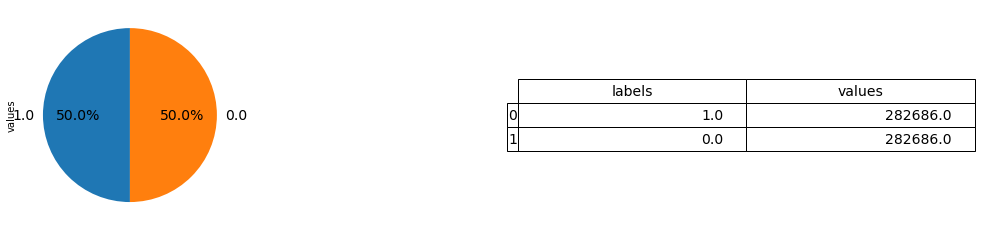

In [23]:
%matplotlib inline
# Checking if the Target varaible is balanced
contract_value_counts = df['TARGET'].value_counts()
contract_df = pd.DataFrame({'labels': contract_value_counts.index,'values': contract_value_counts.values})
# plot a piechart
ax1 = plt.subplot(121, aspect='equal')
contract_df.plot(kind='pie', y = 'values', ax=ax1, autopct='%1.1f%%', 
startangle=90, shadow=False, labels=contract_df['labels'], legend = False, fontsize=14, figsize=(9,4))

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
tbl = pp.table(ax2, contract_df, loc='right')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
tbl.scale(2,2)
plt.show()

### 2.5 Select columns by feature importance

In [34]:
# Limiting number of rows so that the feature selection algoritm below perfroms better
Y= Y[:50000]
X = X.head(50000)

In [35]:
forest=RandomForestClassifier(n_jobs=4, class_weight='balanced', max_depth=5,random_state=1)
boruta=BorutaPy(estimator=forest, n_estimators='auto', max_iter=100,verbose=2, random_state=1)
boruta.fit(np.array(X), np.array(Y))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	412
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	73
Tentative: 	16
Rejected: 	323
Iteration: 	9 / 100
Confirmed: 	73
Tentative: 	16
Rejected: 	323
Iteration: 	10 / 100
Confirmed: 	73
Tentative: 	16
Rejected: 	323
Iteration: 	11 / 100
Confirmed: 	73
Tentative: 	16
Rejected: 	323
Iteration: 	12 / 100
Confirmed: 	73
Tentative: 	16
Rejected: 	323
Iteration: 	13 / 100
Confirmed: 	73
Tentative: 	12
Rejected: 	327
Iteration: 	14 / 100
Confirmed: 	73
Tentative: 	12
Rejected: 	327
Iteration: 	15 / 100
Confirmed: 	73
Tentative: 	12
Rejected: 	327
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=248, n_jobs=4, oob_score=False,
            random_state=<mtrand.RandomState object at 0x000002DD9FA1BCF0>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x000002DD9FA1BCF0>,
     two_step=True, verbose=2)

In [36]:
green_area=X.columns[boruta.support_].to_list()
blue_area=X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area, len(green_area))
print('features in the blue area:', blue_area, len(blue_area))

features in the green area: ['AMT_CREDIT_SUM', 'buro_count', 'CREDIT_ACTIVE_Active', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT', 'CREDIT_ACTIVE_Closed', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD_DEF_x', 'SK_DPD_x', 'MONTHS_BALANCE_x', 'DAYS_TERMINATION', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'AMT_GOODS_PRICE_y', 'AMT_ANNUITY', 'CNT_PAYMENT', 'NAME_GOODS_CATEGORY_XNA', 'NAME_PORTFOLIO_POS', 'NAME_PRODUCT_TYPE_walk-in', 'PRODUCT_COMBINATION_Cash X-Sell: low', 'NAME_YIELD_GROUP_low_normal', 'NAME_YIELD_GROUP_XNA', 'NAME_YIELD_GROUP_high', 'NAME_PAYMENT_TYPE_XNA', 'NAME_PAYMENT_TYPE_Cash through the bank', 'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CLIENT_TYPE_New', 'CODE_REJECT_REASON_XAP', 'AMT_APPLICATION', 'NAME_CONTRACT_TYPE_Consumer loans', 'SELLERPLACE_AREA', 'DAYS_DECISION', 'HOUR_APPR_PROCESS_START_y', 'AMT_CREDIT_y', 'AMT_PAYMENT', 'AMT_PAYMENT_x', 'AMT_PAYMENT_y', 'DAYS_ENTRY_PAYMENT', 'DAYS_ENTRY_PAY

In [37]:
y= df.TARGET
data = df[green_area]
data.shape

(565372, 74)

In [38]:
#Adding target variable to the features dataframe
data['TARGET']=y

#Confirm it was added
print(data.shape)

(565372, 75)


D:\Anaconda\envs\pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Export the final dataset

In [39]:
data.to_csv('Data/final_dataset_v3.csv',index=False)